In [96]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt

def an_post(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( log_posterior(xt, np.array([w0, w1, w2]), alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( log_posterior(xt, np.array([w1, w0, w2]), alpha  ) ) ) 
            else: w1y.append( np.exp( log_posterior(xt, np.array([w2, w1, w0]), alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.array( [ np.dot(xt[i], omega) for i in range(len(xt)) ] ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, omega, omega_new):
            omega = omega_new
            c +=1
            accepted.append(omega)
    return np.array(accepted)

def log_acceptance_diri(xt, alpha, omega, omega_new):
    return log_posterior(xt, omega_new, alpha) - log_posterior(xt, omega, alpha) + dirichlet.logpdf(omega_new, alpha = alpha) - dirichlet.logpdf(omega, alpha = alpha)



In [97]:
n_pars = 3
hm = 6
xt = generate_xt(n_pars, hm)
print(xt)

[[0.74178353 0.21196488 0.04625159]
 [0.77861016 0.17838473 0.04300511]
 [0.61762047 0.3455135  0.03686604]
 [0.65132074 0.28673508 0.06194418]
 [0.31075894 0.62864458 0.06059648]
 [0.67815101 0.23523367 0.08661533]]


In [98]:
a = 1
alpha = np.ones(n_pars)*a

n = int(1e5)

samples = sampling(n, xt, alpha)

Acceptance rate 0.617146: 100%|██████████| 100000/100000 [01:22<00:00, 1218.08it/s]


In [101]:
anal_x = []
anal = []
for i in range(n_pars):
    x,y = an_post(i, 1000, xt, alpha)
    anal_x.append(x)
    anal.append(y)


100%|██████████| 1000/1000 [00:18<00:00, 53.77it/s]


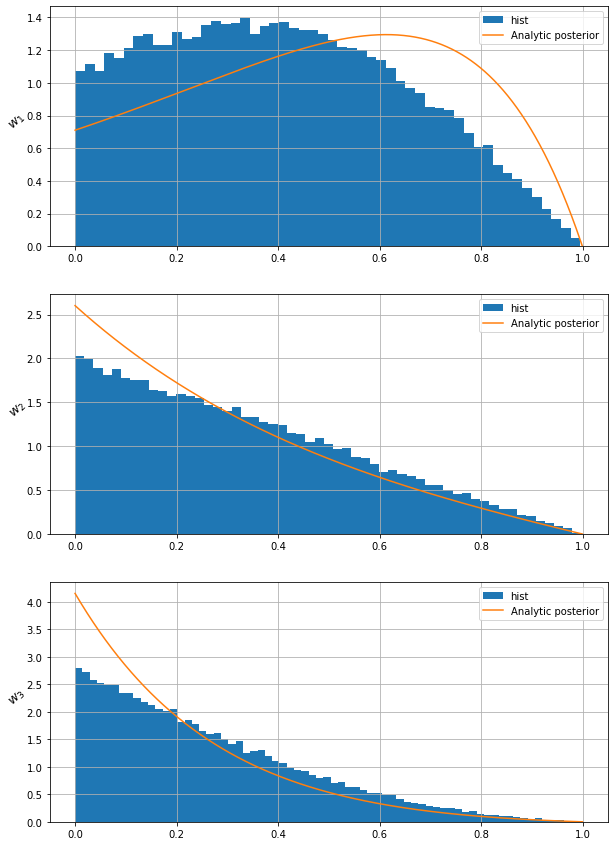

In [102]:
fig, axs = plt.subplots( n_pars, figsize = [10,15] )
w = samples
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', density = True, label = 'hist')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].plot(anal_x[i], anal[i], label = 'Analytic posterior')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()